# Forecast API

This notebook shows basic usage of the Contrail Forecast ([/v1/grids](https://api.contrails.org/openapi#/Forecast/get_grids_v1_grids_get), [/v1/regions](https://api.contrails.org/openapi#/Forecast/get_regions_v1_regions_get)) APIs for retrieving GeoJSON polygon regions and netCDF gridded contrail forecast data.

This API implements a [working specification for contrail forecast data](https://contrailcirrus.github.io/contrail-forecast/) designed for  air traffic planners and managers implementing navigational contrail avoidance systems. 

In [1]:
import os

In [2]:
# Load API key
# (contact api@contrails.org if you need an API key)
URL = "https://api.contrails.org"
API_KEY = os.environ["CONTRAILS_API_KEY"]
HEADERS = {"x-api-key": API_KEY}

## Polygon contrail forecast regions

**GET [/v1/regions/](https://api.contrails.org/openapi#/Production%20(beta)/get_regions_v1_regions_aircraft_class__aircraft_class__timestamp__timestamp__flight_level__flight_level__threshold__threshold__get)**

Fetch and visualize contrail forecast regions as GeoJSON polygons at a given flight level.

The `threshold` value must be one of `[1, 2, 3, 4]`.
A threshold of `1` returns contrail regions predicted to create low warming contrails.
A thresold of `4` returns contrail regions predicted to create the most warming contrails.

**This example fetches polygon regions for Oct 15, 2024 12:00 UTC at flight level 330, with threshold value of 3**

In [3]:
import matplotlib.pyplot as plt  # pip install matplotlib
import requests  # pip install requests

# for plotting GeoJSON polygons
import shapely.geometry as sgeom  # pip install shapely

In [4]:
datetime = "2024-10-15T12"  # format ISO8601
aircraft_class = "default"
flight_level = 330
threshold = 3

uri_template = "{URL}/v1/regions?aircraft_class={ac}&time={ts}&flight_level={fl}&threshold={thres}"
uri = uri_template.format(
    URL=URL,
    ac=aircraft_class,
    ts=datetime,
    fl=flight_level,
    thres=threshold,
)
resp = requests.get(uri, headers=HEADERS)
print(f"HTTP Response Code: {resp.status_code} {resp.reason}\n")

HTTP Response Code: 200 OK



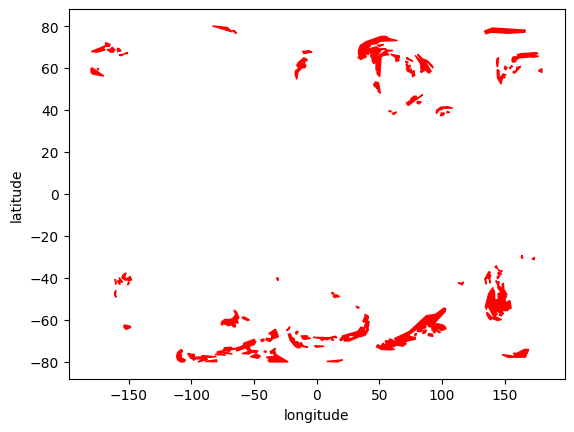

In [5]:
# Extract a feature
regions_geojson = resp.json()
feature = regions_geojson["features"][0]

# Visualize with shapely
polygons = sgeom.shape(feature["geometry"])
for poly in polygons.geoms:
    plt.fill(*poly.exterior.xy, color="red")

plt.xlabel("longitude")
plt.ylabel("latitude");

## NetCDF contrail forecast data

**GET [/v1/grids/](https://api.contrails.org/openapi#/Production%20(beta)/get_grids_v1_grids_aircraft_class__aircraft_class__timestamp__timestamp__flight_level__flight_level__get)**

Fetch and visualize contrail forecast data on a regular grid at a given flight level.

The variable `contrails` in the netCDF object represents a contrail forcing index, ranging from `0` (no contrail warming) to `4` (highly warming).
 
**This example fetches netCDF gridded data for Oct 15, 2024 12:00 UTC at flight level 330**


In [6]:
import xarray as xr  # pip install xarray

In [7]:
# fetch netCDF content from API
datetime = "2024-10-15T12"  # format ISO8601
aircraft_class = "default"
flight_level = 330

uri_template = "{URL}/v1/grids?aircraft_class={ac}&time={ts}&flight_level={fl}"
uri = uri_template.format(
    URL=URL,
    ac=aircraft_class,
    ts=datetime,
    fl=flight_level,
)

resp = requests.get(uri, headers=HEADERS)
print(f"HTTP Response Code: {resp.status_code} {resp.reason}\n")

# Save request to disk, then open with xarray
with open("forecast.nc", "wb") as f:
    f.write(resp.content)

ds = xr.open_dataset("forecast.nc", engine="netcdf4")  # pip install netCDF4

HTTP Response Code: 200 OK



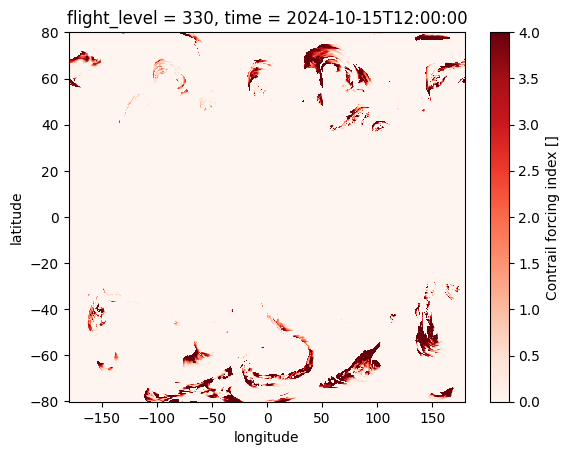

In [8]:
# Plot lat x lon slice for this time x flight level
ds["contrails"].squeeze().plot(x="longitude", y="latitude", cmap="Reds");